## NLP_Capstone_Project

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import re
from nltk.corpus import stopwords
import string
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics    
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import timeit
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import gutenberg, stopwords
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups

## Exploring and modelling the 20 Newsgroups data set

### Dataset description: 
the 20 Newsgroups data set is a collection of approximately 19K newsgroup documents.
The original form of this dataset is at this page: http://qwone.com/~jason/20Newsgroups/    

## Inspiration:
Classifying text documents into various news groups

## Sections:
* Preparing full, train and test data set
* Data cleaning: removing stopwords, filter out short words, stemming and lemmatization
* vectorization: tf_idf
* comparison Naive_Bayes performance between applying stemming and lemmatization 
* Exploring different ngrams in the vectorizer step
* Exploring various ML algorithms: SVC, Logistic regression, Random forest, and Gradient boosting 
* Inspecting the top words calcualted by Naive_bayes
* Text extraction: lsa, lda, and nnmf
* Unsupervised learning with LSA: KMeans and GaussianMixture
* Text summarization: tf_idf, calculate similarity, rank sentences based on scores
* Word2vec


### Preparing the full_dataset, train_dataset and test_dataset

In [15]:
dataset_full = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df_full = pd.DataFrame()
df_full['text'] = dataset_full.data
df_full['source'] = dataset_full.target
label=[]
for i in df_full['source']:
    label.append(dataset_full.target_names[i])
df_full['label']=label

dataset_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df_train = pd.DataFrame()
df_train['text'] = dataset_train.data
df_train['source'] = dataset_train.target
label=[]
for i in df_train['source']:
    label.append(dataset_train.target_names[i])
df_train['label']=label

dataset_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df_test = pd.DataFrame()
df_test['text'] = dataset_test.data
df_test['source'] = dataset_test.target
label=[]
for i in df_test['source']:
    label.append(dataset_test.target_names[i])
df_test['label']=label

### Data cleaning

* Removing stopwords
* Filter out short words
* Lowercase and removing everything except words
* Applying stemming vs lemmatization to the text

In [20]:
stopWords = set(stopwords.words('english'))

def textcleaner_stem(text):
    ''' Takes in raw unformatted text and strips punctuation, removes whitespace,
    strips numbers, tokenizes and stems.
    Returns string of processed text to be used into CountVectorizer
    '''
    # Lowercase and strip everything except words
    cleaner = re.sub(r"[^a-zA-Z ]+", ' ', text.lower())
    # Tokenize
    cleaner = word_tokenize(cleaner)
    ps = PorterStemmer()
    clean = []
    for w in cleaner:
        # filter out stopwords
        if w not in stopWords:
            # filter out short words
            if len(w)>2:
                # Stem 
                clean.append(ps.stem(w))
    return ' '.join(clean)

In [21]:
df_full['clean_text_stem'] = df_full.text.apply(lambda x: textcleaner_stem(x))
df_train['clean_text_stem'] = df_train.text.apply(lambda x: textcleaner_stem(x))
df_test['clean_text_stem'] = df_test.text.apply(lambda x: textcleaner_stem(x))

In [26]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

stopWords = set(stopwords.words('english'))

def textcleaner_lemmas(text):
    ''' Takes in raw unformatted text and strips punctuation, removes whitespace,
    strips numbers, tokenizes and stems.
    Returns string of processed text to be used into CountVectorizer
    '''
    # Lowercase and strip everything except words
    cleaner = re.sub(r"[^a-zA-Z ]+", ' ', text.lower())
    # Tokenize
    cleaner = word_tokenize(cleaner)
    ps = PorterStemmer()
    clean = []
    for w in cleaner:
        # filter out stopwords
        if w not in stopWords:
            # filter out short words
            if len(w)>2:
                # lemmatizer 
                clean.append(lemmatizer.lemmatize(w))
    return ' '.join(clean)

In [27]:
df_full['clean_text_lemma'] = df_full.text.apply(lambda x: textcleaner_lemmas(x))
df_train['clean_text_lemma'] = df_train.text.apply(lambda x: textcleaner_lemmas(x))
df_test['clean_text_lemma'] = df_test.text.apply(lambda x: textcleaner_lemmas(x))

### Converet sentences to vectors: test_stem to tf_idf

In [507]:
vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,2))

x_train_stem = vectorizer.fit_transform(df_train['clean_text_stem'])
y_train_stem = df_train['source']
x_test_stem = vectorizer.transform(df_test['clean_text_stem'])
y_test_stem = df_test['source']
features_train = vectorizer.get_feature_names()
len(features_train)

21465

### Naive_bayes: test the stem_text

In [508]:
from sklearn.naive_bayes import MultinomialNB

# Start timing
start = timeit.default_timer()

#Initialize and fit
nb = MultinomialNB()
nb.fit(x_train_stem, y_train_stem)

# Apply to testing data
y_pred_stem = nb.predict(x_test_stem)

# Stop timing
stop = timeit.default_timer()
nb_time = stop-start
print("Run time: %0.3f" % (nb_time))

# Showing model performance
print("Accuracy is: %0.3f" % nb.score(x_test_stem, y_test_stem))
print(metrics.classification_report(y_test_stem, y_pred_stem, target_names=dataset_test.target_names))

Run time: 0.057
Accuracy is: 0.670
                          precision    recall  f1-score   support

             alt.atheism       0.67      0.17      0.27       319
           comp.graphics       0.63      0.68      0.66       389
 comp.os.ms-windows.misc       0.66      0.57      0.61       394
comp.sys.ibm.pc.hardware       0.59      0.68      0.63       392
   comp.sys.mac.hardware       0.73      0.63      0.68       385
          comp.windows.x       0.76      0.77      0.76       395
            misc.forsale       0.80      0.76      0.78       390
               rec.autos       0.82      0.71      0.76       396
         rec.motorcycles       0.83      0.74      0.78       398
      rec.sport.baseball       0.92      0.79      0.85       397
        rec.sport.hockey       0.57      0.92      0.71       399
               sci.crypt       0.69      0.78      0.73       396
         sci.electronics       0.64      0.51      0.57       393
                 sci.med       0.82     

### Converet sentences to vectors: test_lemma to tf_idf

In [509]:
vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                             ngram_range=(1,2))

x_train_lemma = vectorizer.fit_transform(df_train['clean_text_lemma'])
y_train_lemma = df_train['source']
x_test_lemma = vectorizer.transform(df_test['clean_text_lemma'])
y_test_lemma = df_test['source']
features_train = vectorizer.get_feature_names()
len(features_train)

22027

### Naive_bayes: test the lemma_text

In [510]:
from sklearn.naive_bayes import MultinomialNB

# Start timing
start = timeit.default_timer()

#Initialize and fit
nb = MultinomialNB()
nb.fit(x_train_lemma, y_train_lemma)

# Apply to testing data
y_pred_lemma = nb.predict(x_test_lemma)

# Stop timing
stop = timeit.default_timer()
nb_time = stop-start
print("Run time: %0.3f" % (nb_time))

# Showing model performance
print("Accuracy is: %0.3f" % nb.score(x_test_lemma, y_test_lemma))
print(metrics.classification_report(y_test_lemma, y_pred_lemma, target_names=dataset_test.target_names))

Run time: 0.058
Accuracy is: 0.671
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.19      0.30       319
           comp.graphics       0.63      0.67      0.65       389
 comp.os.ms-windows.misc       0.62      0.57      0.60       394
comp.sys.ibm.pc.hardware       0.59      0.68      0.63       392
   comp.sys.mac.hardware       0.73      0.62      0.67       385
          comp.windows.x       0.75      0.77      0.76       395
            misc.forsale       0.78      0.78      0.78       390
               rec.autos       0.81      0.70      0.75       396
         rec.motorcycles       0.83      0.76      0.79       398
      rec.sport.baseball       0.90      0.79      0.84       397
        rec.sport.hockey       0.57      0.92      0.71       399
               sci.crypt       0.69      0.77      0.73       396
         sci.electronics       0.66      0.52      0.58       393
                 sci.med       0.83     

### Comparison between stemming and lemmatization:
* no significant accuracy different as applying different mothods
* the running time using naive_bayes is quite fast
* the following study will use the lemmatized text

### Exploring different ngrams in the vectorizer step

In [511]:
for n in range(1,4):
    vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                                 ngram_range=(1,n))

    x_train_lemma = vectorizer.fit_transform(df_train['clean_text_lemma'])
    y_train_lemma = df_train['source']
    x_test_lemma = vectorizer.transform(df_test['clean_text_lemma'])
    y_test_lemma = df_test['source']
    features_train = vectorizer.get_feature_names()
    print(len(features_train))
    
# Start timing
    start = timeit.default_timer()

#Initialize and fit
    nb = MultinomialNB()
    nb.fit(x_train_lemma, y_train_lemma)

# Apply to testing data
    y_pred_lemma = nb.predict(x_test_lemma)

# Stop timing
    stop = timeit.default_timer()
    nb_time = stop-start
    print("Run time: %0.3f" % (nb_time))

# Showing model performance
    print("Accuracy is: %0.3f" % nb.score(x_test_lemma, y_test_lemma))

12118
Run time: 0.040
Accuracy is: 0.673
22027
Run time: 0.050
Accuracy is: 0.671
23307
Run time: 0.054
Accuracy is: 0.670


##### As using different ngrams, there is no clear effect on the model prediction accuracy 

### Exploring more ml algorithms: SVC, Logistic regression, Random forest, and Gradient boosting

In [513]:
X_train =  x_train_lemma
Y_train = y_train_lemma
X_test = x_test_lemma 
Y_test = y_test_lemma

### SVC

In [500]:
from sklearn.svm import SVC

# Start timing
start = timeit.default_timer()

# Create instance and fit
sv = SVC(kernel='linear')
sv.fit(X_train, Y_train)

# Apply to testing data
y_pred = sv.predict(X_test)

# Stop timing
stop = timeit.default_timer()
sv_time = stop - start
print("Run time:%0.3f" %sv_time)

# Showing model performance
cross = pd.crosstab(y_pred, Y_test)
print("Accuracy is: %0.3f" % sv.score(X_test, Y_test))
print(metrics.classification_report(Y_test, y_pred, target_names=dataset_test.target_names))

Run time:104.975
Accuracy is: 0.658
                          precision    recall  f1-score   support

             alt.atheism       0.47      0.50      0.49       319
           comp.graphics       0.58      0.68      0.62       389
 comp.os.ms-windows.misc       0.62      0.60      0.61       394
comp.sys.ibm.pc.hardware       0.64      0.64      0.64       392
   comp.sys.mac.hardware       0.69      0.64      0.67       385
          comp.windows.x       0.80      0.64      0.71       395
            misc.forsale       0.77      0.77      0.77       390
               rec.autos       0.44      0.75      0.55       396
         rec.motorcycles       0.67      0.73      0.70       398
      rec.sport.baseball       0.78      0.78      0.78       397
        rec.sport.hockey       0.91      0.82      0.86       399
               sci.crypt       0.84      0.64      0.73       396
         sci.electronics       0.53      0.57      0.55       393
                 sci.med       0.79    

### LogisticRegression

In [515]:
from sklearn.linear_model import LogisticRegression

# Start timing
start = timeit.default_timer()

lr = LogisticRegression()
lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

# Stop timing
stop = timeit.default_timer()
lr_time = stop - start
print("Run time:%0.3f" %sv_time)

# Showing model performance
cross = pd.crosstab(y_pred, Y_test)
print("Accuracy is: %0.3f" % lr.score(X_test, Y_test))
print(metrics.classification_report(Y_test, y_pred, target_names=dataset_test.target_names));

Run time:472.972
Accuracy is: 0.678
                          precision    recall  f1-score   support

             alt.atheism       0.50      0.48      0.49       319
           comp.graphics       0.62      0.67      0.65       389
 comp.os.ms-windows.misc       0.63      0.59      0.61       394
comp.sys.ibm.pc.hardware       0.65      0.62      0.64       392
   comp.sys.mac.hardware       0.70      0.66      0.68       385
          comp.windows.x       0.78      0.71      0.75       395
            misc.forsale       0.75      0.78      0.77       390
               rec.autos       0.74      0.68      0.71       396
         rec.motorcycles       0.73      0.77      0.75       398
      rec.sport.baseball       0.53      0.83      0.64       397
        rec.sport.hockey       0.89      0.89      0.89       399
               sci.crypt       0.85      0.67      0.75       396
         sci.electronics       0.54      0.57      0.55       393
                 sci.med       0.76    

### GradientBoosting

In [516]:
from sklearn import ensemble

# Start timing
start = timeit.default_timer()

gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, Y_train)

pred = gbc.predict(X_test)

# Stop timing
stop = timeit.default_timer()
gbc_time = stop - start
print("Run time:%0.3f" %sv_time)

# Showing model performance
cross = pd.crosstab(y_pred, Y_test)
print("Accuracy is: %0.3f" % gbc.score(X_test, Y_test))
print(metrics.classification_report(Y_test, y_pred, target_names=dataset_test.target_names))


Run time:472.972
Accuracy is: 0.594
                          precision    recall  f1-score   support

             alt.atheism       0.50      0.48      0.49       319
           comp.graphics       0.62      0.67      0.65       389
 comp.os.ms-windows.misc       0.63      0.59      0.61       394
comp.sys.ibm.pc.hardware       0.65      0.62      0.64       392
   comp.sys.mac.hardware       0.70      0.66      0.68       385
          comp.windows.x       0.78      0.71      0.75       395
            misc.forsale       0.75      0.78      0.77       390
               rec.autos       0.74      0.68      0.71       396
         rec.motorcycles       0.73      0.77      0.75       398
      rec.sport.baseball       0.53      0.83      0.64       397
        rec.sport.hockey       0.89      0.89      0.89       399
               sci.crypt       0.85      0.67      0.75       396
         sci.electronics       0.54      0.57      0.55       393
                 sci.med       0.76    

### RandomForest

In [526]:
from sklearn import ensemble

# Start timing
start = timeit.default_timer()

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, Y_train)

y_pred = rfc.predict(X_test)

# Stop timing
stop = timeit.default_timer()
rfc_time = stop - start
print("Run time:%0.3f" %rfc_time)

# Showing model performance
cross = pd.crosstab(y_pred, Y_test)
print("Accuracy is: %0.3f" % rfc.score(X_test, Y_test))
print("Accuracy is: %0.3f" % rfc.score(X_train, Y_train))
print(metrics.classification_report(Y_test, y_pred, target_names=dataset_test.target_names));

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Run time:2.890
Accuracy is: 0.534
Accuracy is: 0.968
                          precision    recall  f1-score   support

             alt.atheism       0.31      0.40      0.35       319
           comp.graphics       0.42      0.53      0.47       389
 comp.os.ms-windows.misc       0.45      0.53      0.49       394
comp.sys.ibm.pc.hardware       0.47      0.45      0.46       392
   comp.sys.mac.hardware       0.57      0.52      0.54       385
          comp.windows.x       0.50      0.53      0.51       395
            misc.forsale       0.58      0.68      0.62       390
               rec.autos       0.37      0.63      0.46       396
         rec.motorcycles       0.65      0.63      0.64       398
      rec.sport.baseball       0.61      0.73      0.66       397
        rec.sport.hockey       0.79      0.70      0.74       399
               sci.crypt       0.71      0.58      0.64       396
         sci.electronics       0.46      0.34      0.39       393
                 sci.m

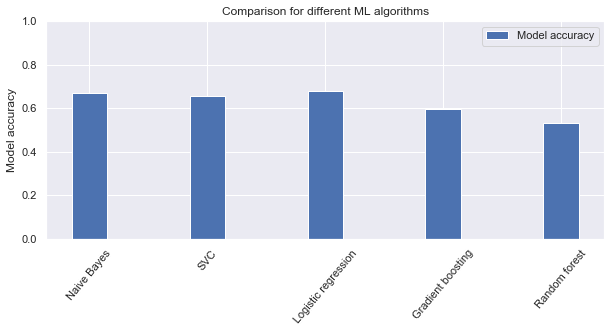

In [675]:
accuracy = [0.671,0.658,0.678,0.594,0.534]

labels = ['Naive Bayes', 'SVC', 'Logistic regression', 'Gradient boosting','Random forest']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
fig, ax = plt.subplots(1, 1,  figsize=(10, 4))
g1 = ax.bar(x, accuracy, width, label='Model accuracy')

ax.set_ylabel('Model accuracy')
ax.set_title('Comparison for different ML algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=50)
ax.set_ylim(0, 1)
ax.legend();

##### Summary: naive bayes and logistice regression performs the best in terms of model prediction accuracy. However, naive bayes running much faster than any other ML models, therefore should be the best algorithms for this test.

### Inspecting the top words calcualted by Naive_bayes

In [689]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))
        
a = show_top10(nb, vectorizer, dataset.target_names)

alt.atheism: islam would say atheism think people one religion atheist god
comp.graphics: would anyone color know format program thanks image file graphic
comp.os.ms-windows.misc: card use win font program problem do driver file window
comp.sys.ibm.pc.hardware: thanks system monitor disk ide bus controller scsi card drive
comp.sys.mac.hardware: quadra simms thanks one card monitor problem drive apple mac
comp.windows.x: program thanks display file use application motif widget server window
misc.forsale: drive asking please sell price condition new shipping offer sale
rec.autos: good ford auto get one dealer would like engine car
rec.motorcycles: dog rider riding like helmet one ride dod motorcycle bike
rec.sport.baseball: pitching fan last hit run baseball player team year game
rec.sport.hockey: goal year playoff nhl season play player hockey team game
sci.crypt: escrow system phone would nsa government clipper encryption chip key
sci.electronics: voltage know like power chip anyone us

##### There are seems five main fields that the news groups trying to focus: computer, recreation, science, religion and politics. Different new groups that reporting the same fields tend to use very similar words, therefore it makes the prediction very hard to distinguish different new groups in the same fields.

### Text extraction: lsa, lda, and nnmf

In [733]:
# Number of topics.
ntopics=20

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)

    return components
    
# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

##### Since we know there are totally 20 news groups, we will use this number now. However, for unsupervised learn, we have to try different numbers and inpect the clusters.

### LSA

In [716]:
terms = vectorizer.get_feature_names()

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_group_lsa = lsa.fit_transform(x_train_lemma)

components_lsa = word_topic(x_train_lemma, news_group_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

### LDA

In [717]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

news_group_lda = lda.fit_transform(x_train_lemma) 

components_lda = word_topic(x_train_lemma, news_group_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

### NNMF

In [718]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_group_nmf = nmf.fit_transform(x_train_lemma) 

components_nmf = word_topic(x_train_lemma, news_group_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [719]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
            LSA          LDA         NNMF
0     one 118.6   window 4.5     one 3.51
0  would 118.34     one 3.94  people 2.92
0    like 87.81    card 3.79    think 2.7
0    know 85.74   would 3.78   would 2.48
0     get 85.64    know 3.39      get 2.3
0  people 81.14     like 3.3    like 2.25
0    think 78.4    file 3.24    know 2.07
0    time 72.95     get 3.13    time 2.04
0    good 65.29  anyone 3.09   thing 2.01
0    also 63.16  thanks 3.06     say 1.94
Topic 1:
             LSA            LDA         NNMF
1   window 40.99  armenian 5.27  problem 3.1
1   thanks 29.62       one 3.53  system 1.86
1      file 26.6    people 3.29     use 1.76
1     drive 24.5     would 3.06    work 1.41
1     card 24.13   turkish 2.51   using 1.34
1       do 19.12      know 2.49  window 1.34
1  program 18.19      like 2.32     one 1.31
1   please 16.86       get 2.26     get 1.29
1   anyone 16.82      test 2.22   would 1.19
1      use 16.76     think 2.15   color 1.09
Topic 2:
                

14  palestinian 5.66   good 1.88         war 1.05
Topic 15:
                LSA           LDA             NNMF
15      would 30.62      one 2.38       would 7.67
15       like 18.56    would 2.12         like 3.4
15        file 13.5     like 1.94  would like 1.94
15  would like 9.79      get 1.88         one 1.83
15    armenian 8.02      know 1.8        know 1.62
15       sound 7.01  feustel 1.65         get 1.52
15       offer 6.79      key 1.56       could 1.45
15        game 6.44      com 1.48       think 1.45
15        sale 6.26     time 1.39      people 1.34
15       price 5.03   anyone 1.37        also 1.27
Topic 16:
                LSA           LDA         NNMF
16      would 22.61  window 56.24     car 6.91
16      space 14.56   would 51.46    bike 2.05
16        car 12.69  thanks 49.52  engine 1.22
16       system 9.6     one 47.55     one 1.12
16      driver 8.17    know 45.79    mile 1.11
16        nasa 6.41     get 43.28   would 1.05
16       anyone 6.1    like 42.99    lik

### Inspecting the weight of word in different topics

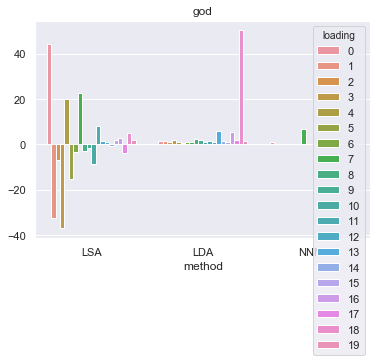

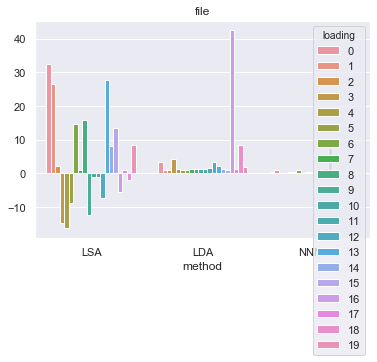

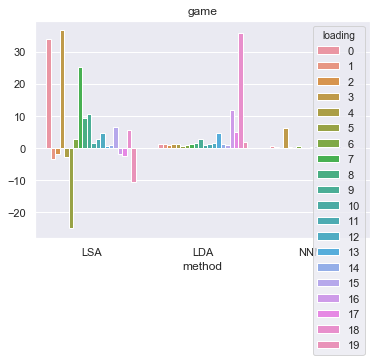

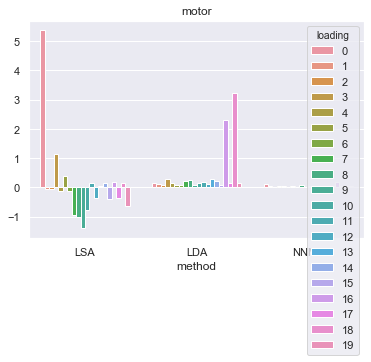

In [727]:
# The words to look at.
targetwords=['god','file','game','motor']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 20, axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
#     plt.tight_layout()
    plt.show()

##### Summary: for the first 4 words, LDA and NNMF showed a more clearly emphasizing on one particle topics than LSA. For the word 'motor', it seems LSA works better in classifying the topics.

### Unsupervised learning with LSA: KMeans and GaussianMixture

In [744]:
# kmean
x_norm = normalize(news_group_lsa)

kmeans = KMeans(n_clusters=20, random_state=123)
y_predict = kmeans.fit_predict(x_norm)

# Check the solution against the data.
print('Comparing k-means clusters against news groups:')
print(pd.crosstab(Y_train, y_predict))

Comparing k-means clusters against news groups:
col_0    0    1    2    3    4    5    6    7    8   9   10   11   12   13  \
source                                                                       
0         2    2    5  199    0    7   22    0    3   7  12   15    2    1   
1         1   11  127   12   45    0   13   26    1  90  16   38  114    5   
2         0    8   50    4   76    1    9  185    1  33  34   11  107    4   
3         0   14   73    9  154    0   14   29    3  48  12    8   13    8   
4         0   37  139    8  100    0   29    2    0  70  22    7    6    8   
5         0    1  191    6    6    0    6  154    2  60   5   12   55   13   
6         0  330    9    8   26    0    7   19   11  11   8   16    2    5   
7         1   12   18   21    0    0   94    5    0  24  34   17    0    5   
8         1   17    8   36    2    0  359    2    4  21  15   14    3    0   
9         0    3    1   30    0    5   62    1  352  29  30   25    2    1   
10        0    2

In [746]:
# GaussianMixtureModel
from sklearn.mixture import GaussianMixture

gmm_cluster = GaussianMixture(n_components=20, random_state=123)
clusters = gmm_cluster.fit_predict(news_group_lsa)

# Check the solution against the data.
print('Comparing k-means clusters against news groups:')
print(pd.crosstab(Y_train, clusters))

Comparing k-means clusters against news groups:
col_0    0    1    2    3    4   5    6    7    8    9    10   11   12  13  \
source                                                                       
0         2    4   16    0    2  12   73    1  115    5    0   16   79  14   
1        10    4   73    4    0  16    0  100    0    0  154   21   14  69   
2         1    3   64   20    0  33    2  119    0    0  197   14    4  21   
3        18    5   88  181    0  12    0   31    0    1   24   10    2  24   
4        40    3  117  105    0  21    0   32    0    4   14    5    7  28   
5         1   14   58    3    0   5    0  268    0    0  108   15    4  49   
6       252    1   55  101    0   8    0   20    0   12    7   24   15  26   
7        37    3   75    2    1  33    8    3    0  282    0    6   25  26   
8        33    1   44    7    6  15   11    2    3   81    1   21   30  28   
9        86    2    7    1  264  29    1    0    1    1    0   26   72  56   
10       76    0

##### Summary: it seems both kmeans and GaussianMixtureModel does not work very well

### Text summarization

### Selecting 3 news_groups and choosing the highest score sentence to summarize the text

In [861]:
for news_group in ['rec.autos','rec.sport.baseball','talk.politics.mideast']:

    auto = df_train[df_train['label']== news_group]['text'][:50]
    auto_str = ' '.join(auto)


# Importing the text the lazy way.
    text = auto_str

# We want to use the standard english-language parser.
    parser = spacy.load('en')
    
# Parsing Gatsby.
    text = parser(text)

# Dividing the text into sentences and storing them as a list of strings.
    sentences=[]
    for span in text.sents:
    # go from the start to the end of each span, returning each token in the sentence
    # combine each token using join()
        sent = ''.join(text[i].string for i in range(span.start, span.end)).strip()
        sentences.append(sent)

# Creating the tf-idf matrix.
    counter = TfidfVectorizer(lowercase=False, 
                              stop_words=None,
                              ngram_range=(1, 1), 
                              analyzer=u'word', 
                              max_df=.5, 
                              min_df=1,
                              max_features=None, 
                              vocabulary=None, 
                              binary=False)

#Applying the vectorizer
    data_counts=counter.fit_transform(sentences)
    
# Calculating similarity
    similarity = data_counts * data_counts.T

# Identifying the sentence with the highest rank.
    nx_graph = nx.from_scipy_sparse_matrix(similarity)
    ranks=nx.pagerank(nx_graph, alpha=.85, tol=.00000001)

    ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),
                reverse=True)
    print('Topic: {}'.format(news_group))
    print(ranked[0])
    print()

Topic: rec.autos
(0.004536602182237048, '"If you buy the Supra, your rate classification will be the same as\nthe Celica (the \'85 Celica was considered a subcompact and for that\nyear was rated as one of the safest cars), with a slight increase because\nthe car will be 2 years newer.')

Topic: rec.sport.baseball
(0.002830155469389331, "Even if Robinson's extra 3 putouts, 2 assists, and 5 DPs are taken to mean\nhe was responsible for 10 more outs in the field, that doesn't make up\nfor the extra 28 outs he made at the plate, not to mention the fewer\ntotal bases.")

Topic: talk.politics.mideast
(0.0020860798328957296, 'Yet despite the efforts of the x-Soviet Armenian government and its terrorist\nand revisionist organizations, in the last decades, thanks to the struggle \nof those whose closest ones were systematically exterminated by the Armenians,\nthe international wall of silence on this issue has begun to collapse, and \nconsequently a number of governments and organizations have 

##### Summary: from the sentence selected by each news_group, it seems can be used for identifying the field of news very well.

### word2vec

In [28]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [29]:
news_lines=list()
lines = df_train['clean_text_lemma'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    tokens = [w.lower() for w in tokens]
    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    news_lines.append(words)

In [30]:
import gensim
# from gensim.models import Word2Vec

model = gensim.models.Word2Vec(sentences=news_lines, window=5, workers=4, min_count=5)
# model=Word2Vec(sentences=review_lines)

words = list(model.wv.vocab)
print('vocabulary size: %d' % len(words))

vocabulary size: 17151


##### Exploring the similarities between different words

In [623]:
vocab = model.wv.vocab.keys()

print(model.wv.most_similar(positive=['hard', 'drive', 'floppy'], negative=['god']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('drive', 'floppy'))
print(model.wv.similarity('drive', 'think'))

# One of these things is not like the other...
print(model.doesnt_match("hard disk drive think".split()))

[('disk', 0.9235545992851257), ('ide', 0.8905043005943298), ('tape', 0.8877245783805847), ('controller', 0.8873456716537476), ('syquest', 0.873569905757904), ('cable', 0.8652119636535645), ('meg', 0.860806405544281), ('motherboard', 0.8473582863807678), ('quantum', 0.8438715934753418), ('internal', 0.8411087393760681)]
0.90416545
0.21537118


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  # This is added back by InteractiveShellApp.init_path()


think


##### Finding the most similar and dissimilar words

In [927]:
print(model.wv.most_similar(negative=["floppy"]))
print()
print(model.wv.most_similar(positive=["floppy"]))

[('jewish', 0.25071102380752563), ('history', 0.24265269935131073), ('hfe', 0.23397359251976013), ('greek', 0.23135961592197418), ('turkish', 0.2268770933151245), ('organization', 0.21128369867801666), ('president', 0.2112763524055481), ('ozal', 0.21043533086776733), ('israeli', 0.20508508384227753), ('exterminate', 0.20407864451408386)]

[('tape', 0.9751332998275757), ('seagate', 0.9721575379371643), ('reformat', 0.9692538976669312), ('controller', 0.969180166721344), ('pli', 0.9634204506874084), ('disk', 0.9633415937423706), ('ide', 0.9631323218345642), ('meg', 0.9579814672470093), ('iisi', 0.9563916921615601), ('quantum', 0.9560303092002869)]


##### Plotting similar and dissimilar words in a 2-D plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 19 to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

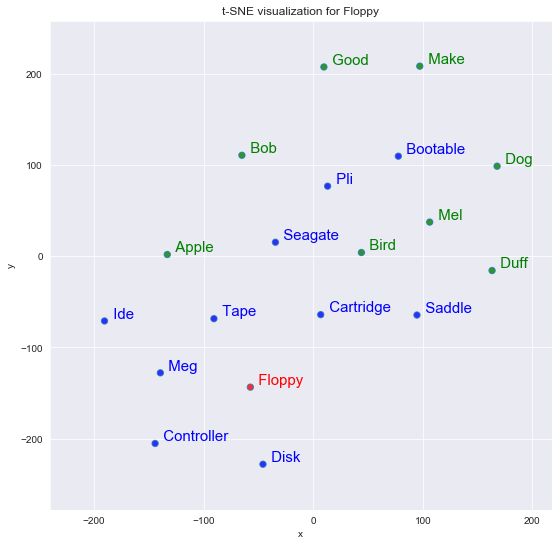

In [34]:
tsnescatterplot(model, 'floppy', ['dog', 'bird', 'good', 'make', 'bob', 'mel', 'apple', 'duff'])

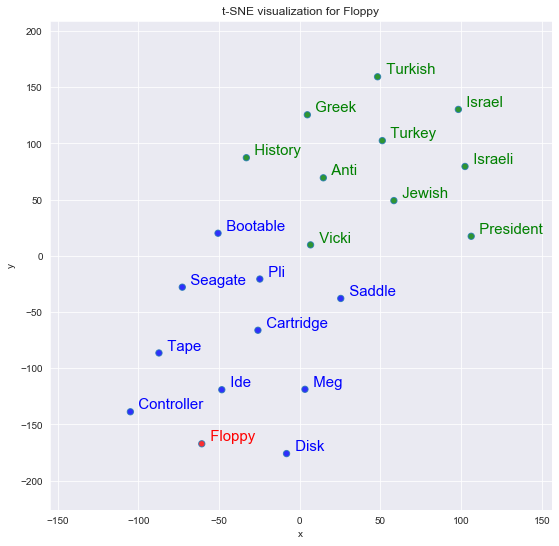

In [40]:
tsnescatterplot(model, 'floppy', [i[0] for i in model.wv.most_similar(negative=["floppy"])]);

##### Summary: word2vec works very well to identify similar words or extract words which are different from others

## Conclusion:

* As applying stemming or lemmatization to the text did not alter the machine learning model accuracy significantly
* Model results did not changed much as using different ngrams in the vectorization step
* Various supervised machine learning models were studied and Naive_Bayes seems worked best interms of model accuracy and efficiency
* The top words calucated by Naive_Bayes model seems highly correlated with their corresponding news groups
* Text extraction were performed using LSA, LDA, and NNMF, and they showed clearly different performace for different topics
* Unsupervised learning: KMeans and GaussianMixtureModel were explorated in this project and both of them are not promising for identifying news groups
* Text summarization techniques were used and it seems works well for select the most representative sentence
* Word2vec has worked successfully for finding similar and dissimilar words 